# **NOTE for Colab Users**

# **Do NOT write directly in this file—your work might be lost!**

# **Always make a copy before you start.**

How to make a copy

1. Click "File" in the top left.
> *If you can’t find the header (like “File” or "Runtime"), click the “v” mark at the top right to show it.*

2. "Save a copy in Drive"

3. Change the copied file’s name to “YOURNAMEs\_FileName.ipynb”.
> Ex: If your name is Olivia : Olivias_FileName.ipynb



---

* Check marks (✅) won’t be saved. If you reload the page with Chrome’s refresh button, they’ll disappear.<br>
If you want to pause and come back later, just add a text cell and write something like “SO FAR DONE.”

---

* In Colab, **previous outputs reset every 30 to 90 minutes**.<br>
  Because of this, errors like `~~ is not defined` will happen **very often**.

  🔁 What to do when you get an `~~is not defined` error
  1. First, make sure your variable is spelled right.<br>
  2. If it’s spelled right but you still see the error, **click the cell you want to restart**.<br>
  3. Go to “Runtime” (top left) → Click “Run before”.<br>
    → This will **re-run all previous cells**.
  4. Run the cell again.

  If you still see the error after these steps,<br>
  there might be a basic mistake in your TODO answers from earlier cells.<br>
  Please check if your answer is right.<br>
  Or ask ChatGPT or another coding assistant for help.

# **Preparation**

This section only loads content from earlier chapters.<br>
Just run the code—you don’t need to read it.<br>
Feel free to skip ahead.<br>

In [ ]:
# Donwload the file
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# Load the file called input.text that you just downloaded in utf-8.
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# A Function to Display Tensors Nicely (Feel Free to Skip This)
import torch
import torch.nn as nn
import torch.nn.functional as F

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("name", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """

    # Determine tensor and name from arguments
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Convert Tensor to List
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """Formatting a recursively nested list and returning a string"""
        # If the contents are lists, then re-return
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # For numerical lists
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # Formatted string (bar brackets on outermost frames are removed)
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # Result output
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")

--2025-07-08 11:25:56--  https://raw.githubusercontent.com/HayatoHongo/nanoGPT_todo/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-07-08 11:25:56 (31.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



# **Chapter 12 Trainer Class**

### **Section 1: Class Definition**

🔘 **Options**: There may be extra options you don't need.

`self.model`　`self.optimizer`　`self.data_loader`　`self.config`　`split_data`　`get_batch`　`'train'`, `'val'`　`input_batch`　`target_batch`　`logits`　`self.config.total_training_steps`　`self.config.evaluation_loops`  
`loss`　`backward()`　`self.train_step()`　`self.evaluate()`

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # Get a batch for training.
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # Model forward pass and loss calculation
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # Backpropagation (Error backpropagation)
        self.optimizer.step()  # Update parameters

        return loss.item() # Returns the value of the loss

    def evaluate(self):
        self.model.eval()  # Set to evaluation mode
        losses = {"train": [], "val": []} # Calculate losses on both training and validation data
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # Return to training mode

        # Calculate the average losses for each split (train, val)
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # Run train_step the number of times specified in config.
        for step in range(self.config.total_training_steps):

            # Evaluate every 100 iterations or just at the final step.
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # One step of training (the main process that you do every time)
            train_loss = self.train_step()

In [ ]:
"""
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # Get a batch for training.
        input_batch, target_batch = ___________._______(_____)
        self.optimizer.zero_grad()

        # Model forward pass and loss calculation
        logits, loss = _______(_________, __________)
        _____.__________  # Backpropagation (Error backpropagation)
        self.optimizer.step()  # Update parameters

        return loss.item() # Returns the value of the loss

    def evaluate(self):
        self.model.eval()  # Set to evaluation mode
        losses = {"train": [], "val": []} # Calculate losses on both training and validation data
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # Return to training mode

        # Calculate the average losses for each split (train, val)
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # Run train_step the number of times specified in config.
        for step in range(_________________________):

            # Evaluate every 100 iterations or just at the final step.
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # One step of training (the main process that you do every time)
            train_loss = _____________
"""


'\nclass Trainer:\n    def __init__(self, model, optimizer, data_loader, config):\n        self.model = model\n        self.optimizer = optimizer\n        self.data_loader = data_loader\n        self.config = config\n\n    def train_step(self):\n        # Get a batch for training.\n        input_batch, target_batch = ___________._______(_____)\n        self.optimizer.zero_grad()\n\n        # Model forward pass and loss calculation\n        logits, loss = _______(_________, __________)\n        _____.__________  # Backpropagation (Error backpropagation)\n        self.optimizer.step()  # Update parameters\n\n        return loss.item() # Returns the value of the loss\n\n    def evaluate(self):\n        self.model.eval()  # Set to evaluation mode\n        losses = {"train": [], "val": []} # Calculate losses on both training and validation data\n        with torch.no_grad():\n            for split in [\'train\', \'val\']:\n                for _ in range(self.config.evaluation_loops):\n     

<details>
<summary>Click here to show/hide the answer</summary>

```python
class Trainer:
    def __init__(self, model, optimizer, data_loader, config):
        self.model = model
        self.optimizer = optimizer
        self.data_loader = data_loader
        self.config = config

    def train_step(self):
        # Get a batch for training.
        input_batch, target_batch = self.data_loader.get_batch('train')
        self.optimizer.zero_grad()

        # Model forward pass and loss calculation
        logits, loss = self.model(input_batch, target_batch)
        loss.backward()  # Backpropagation (Error backpropagation)
        self.optimizer.step()  # Update parameters

        return loss.item() # Returns the value of the loss

    def evaluate(self):
        self.model.eval()  # Set to evaluation mode
        losses = {"train": [], "val": []} # Calculate losses on both training and validation data
        with torch.no_grad():
            for split in ['train', 'val']:
                for _ in range(self.config.evaluation_loops):
                    input_batch, target_batch = self.data_loader.get_batch(split)
                    _, loss = self.model(input_batch, target_batch)
                    losses[split].append(loss.item())
        self.model.train()  # Return to training mode

        # Calculate the average losses for each split (train, val)
        return {split: sum(values) / len(values) for split, values in losses.items()}

    def train(self):
        # Run train_step the number of times specified in config.
        for step in range(self.config.total_training_steps):

            # Evaluate every 100 iterations or just at the final step.
            if step % self.config.evaluation_frequency == 0 or step == self.config.total_training_steps - 1:
                eval_loss = self.evaluate()
                print(f"Step {step}: Train Loss {eval_loss['train']:.4f}, Validation Loss {eval_loss['val']:.4f}")

            # One step of training (the main process that you do every time)
            train_loss = self.train_step()
```

**`Chapter 11: Trainer Class: Section 1: Class Definition`** <label><input type="checkbox"> Mark as Done</label>

### **Section 2: Class Summary**

Paste all classes from Chapter 1 to Chapter 11.<br>
**Replace DeterministicDropout with nn.Dropout.**

[Watch the video!](https://youtu.be/j2ErzvlslKA)
- no audio
- 4 minutes

In the video, the file name is answer_colab, but do not mind.

```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```

In [ ]:
class DataLoader:
    def __init__(self, text, config):
        self.config = config  # Configuration Object
        chars = sorted(list(set(text)))  # Sorting unique characters
        self.ctoi = {char: index for index, char in enumerate(chars)}
        self.itoc = {index: char for index, char in enumerate(chars)}
        self.vocab_size = len(chars)

        # Encode and convert to tensor.
        # `self.` is required to call other methods or arguments outside this `__init__` method.
        self.data = torch.tensor(self.encode(text), dtype=torch.long)

        # Split into training/verification data.
        # `self.data` is used by default even if no argument is specified.
        self.train_data, self.val_data = self.split_data()

    def encode(self, text):
        # Converts a string to an index column. `self.` is required to call other methods or arguments.
        return [self.ctoi[c] for c in text]

    def decode(self, indices):
        return ''.join([self.itoc[i] for i in indices])

    def split_data(self):
        split_index = int(0.9 * len(self.data))  # A split point to make 90% of the data for training.
        return self.data[:split_index], self.data[split_index:]

    def get_batch(self, split):
        data = self.train_data if split == 'train' else self.val_data
        start_indices = torch.randint(len(data) - self.config.input_sequence_length, (self.config.batch_size,)) # Generate extract start index

        input_sequences = torch.stack([
            data[start_index:start_index + self.config.input_sequence_length]
            for start_index in start_indices
        ])
        target_sequences = torch.stack([
            data[start_index + 1:start_index + self.config.input_sequence_length + 1]
            for start_index in start_indices
        ])
        return input_sequences.to(self.config.device_type), target_sequences.to(self.config.device_type)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Define an embedded table for vocabulary number x number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # Get the embedded vector corresponding to the input index
        return self.token_embedding_table.forward(input_indices)

class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # Location embedding layer
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # The shape of the input tensor input_indices: [batch size, sequence length].
        sequence_length = input_indices.shape[1]

        # Create a position index according to the sequence length (e.g. [0, 1, 2, ..., sequence_length-1])
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # Get the embedded vector for the position index
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings

class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Embedded layer for each token
        self.token_embedding_layer = TokenEmbedding(vocab_size = vocab_size, embedding_dim = config.embedding_dim)  # Word embedding layer
        self.position_embedding_layer = PositionEmbedding(input_sequence_length = config.input_sequence_length, embedding_dim = config.embedding_dim)  # Embed location information

    def forward(self, input_indices):
        # Get token embedding
        token_embeddings = self.token_embedding_layer.embed(input_indices)

        # Get location embedding
        position_embeddings = self.position_embedding_layer.forward(input_indices)

        # Adding token embedding and position embedding
        embeddings = position_embeddings + token_embeddings
        return embeddings

class LayerNorm(nn.Module):  # Inherit nn.Module here
    def __init__(self, token_length, eps=1e-5, norm_dim=-1):
        super().__init__()
        self.eps = eps
        self.norm_dim = norm_dim

        # Register gamma and beta as nn.Parameter for use on both CPU and CUDA
        self.gamma = nn.Parameter(torch.ones(token_length))
        self.beta = nn.Parameter(torch.zeros(token_length))

    def forward(self, x):
        mean = torch.mean(x, dim=self.norm_dim, keepdim=True)
        var = torch.var(x, dim=self.norm_dim, keepdim=True, unbiased=False)
        hat = (x - mean) / torch.sqrt(var + self.eps)
        output =  self.gamma * hat + self.beta
        return output


class AttentionHead(nn.Module):
    def __init__(self, head_size, config):
        super().__init__()
        self.key_fc= nn.Linear(config.embedding_dim, head_size, bias=False)
        self.query_fc = nn.Linear(config.embedding_dim, head_size, bias=False)
        self.value_fc = nn.Linear(config.embedding_dim, head_size, bias=False)

        # Masks are created using the lower triangular matrix (maintaining the causality of self-attention)
        self.register_buffer('tril', torch.tril(torch.ones(config.input_sequence_length, config.input_sequence_length)))

        # Dropout (deterministic version is defined separately)
        self.dropout = nn.Dropout(config.dropout_rate)

        self.head_size = head_size

    def forward(self, input_tensor):
        B, T, C = input_tensor.shape  # Batch, Token Length, Embedding Channel

        Key = self.key_fc.forward(input_tensor)     # (B, T, head_size)
        Query = self.query_fc.forward(input_tensor)   # (B, T, head_size)
        Value = self.value_fc.forward(input_tensor)   # (B, T, head_size)

        # Calculating Attention score (QK^T) / sqrt(embedding_dim)
        attention_weights_before_mask = Query @ Key.transpose(-2, -1) * self.head_size**(-0.5)

        # Mask applied
        mask = torch.triu(torch.ones(T, T), diagonal=1).to(input_tensor.device)
        masked_attention_weights = attention_weights_before_mask.masked_fill(mask == 1, float('-inf'))

        # Softmax → Dropout → Weighted sum
        attention_weights = F.softmax(masked_attention_weights, dim=-1)
        attention_weights = self.dropout(attention_weights)

        out = attention_weights @ Value  # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_attention_heads = config.num_attention_heads
        self.embedding_dim = config.embedding_dim
        self.head_size = int(self.embedding_dim / self.num_attention_heads)

        # Manage multiple heads with ModuleList
        self.attention_heads = nn.ModuleList([
            AttentionHead(self.head_size, config)
            for _ in range(self.num_attention_heads)
        ])

        # Linear layer for mixing the outputs of each head
        self.output_projection = nn.Linear(self.embedding_dim, self.embedding_dim)

        # Dropouts for output
        self.dropout = nn.Dropout(config.dropout_rate)

    def forward(self, input_tensor):
        # Get output from each head
        # List of (B, T, head_size)
        head_outputs_list = [head.forward(input_tensor) for head in self.attention_heads]

        # Concatenate outputs of all heads → (B, T, embedding_dim)
        concatenated = torch.cat(head_outputs_list, dim=-1)

        # Mixing outputs with linear transformation
        projected = self.output_projection.forward(concatenated)

        # Apply dropout to final output
        output = self.dropout.forward(projected)

        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embedding_dim, config.hidden_dim),
            nn.ReLU(),
            nn.Linear(config.hidden_dim, config.embedding_dim),
            nn.Dropout(config.dropout_rate),
        )

    def forward(self, input_tensor):
        return self.net(input_tensor)

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Each LayerNorm instance stores its own scaling parameters beta and gamma.
        self.layer_norm1 = nn.LayerNorm(config.embedding_dim)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dim)

        self.multihead_attention = MultiHeadAttention(config=config)
        self.feed_forward = FeedForward(config=config)

    def forward(self, input_tensor):
        # forward method is omitted.
        normed_input = self.layer_norm1(input_tensor) # Apply Layer Norm to input
        attention_output = self.multihead_attention(normed_input) # Apply multi-head attention
        residual_attention = attention_output + input_tensor # add "before! layernorm1
        normed_attention = self.layer_norm2(residual_attention) # Apply LayerNorm again to residual output
        feedforward_output = self.feed_forward(normed_attention) # Apply feedforward network (FFN)
        final_output = feedforward_output + residual_attention # add "before" layernorm2!

        return final_output

class VocabularyLogits(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        # Layer normalization
        self.output_norm = nn.LayerNorm(config.embedding_dim)
        # Projection on vocabulary size
        self.vocab_projection = nn.Linear(config.embedding_dim, vocab_size)

    def forward(self, transformer_block_output):
        # Apply Layer normalization to the output from the Transformer block.
        normalized_output = self.output_norm.forward(transformer_block_output)  # (B, T, C)

        # Projects input scores into the vocabulary-size dimension using a linear layer.
        vocab_logits = self.vocab_projection.forward(normalized_output)  # (B, T, V)

        return vocab_logits

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config  # It is also used when generating, so keep it.
        self.embedding = EmbeddingModule(vocab_size, config=config)
        self.blocks = nn.Sequential(*[TransformerBlock(config=config) for _ in range(config.layer_count)])
        self.vocab_projection = VocabularyLogits(vocab_size=vocab_size, config=config)
        self.criterion = nn.CrossEntropyLoss()

    # Generate text
    def generate(self, input_indices, max_new_tokens):
        # Generate only the specified number of tokens `max_new_tokens`
        for _ in range(max_new_tokens):
            input_conditioned = input_indices[:, -self.config.input_sequence_length:] # Clip input

            # Forward pass returns `(likelihood, loss)`—store only the `likelihood` as `logits`.
            logits, _ = self.forward(input_conditioned, target_indices=None)
            last_logits = logits[:, -1, :] # Extract logit for the last token position
            probs = F.softmax(last_logits, dim=-1) # Convert likelihood to probability with Softmax

            # Sample the next token
            next_token = torch.multinomial(probs, num_samples=1)

            # Consolidate new tokens, update `input_indices`.
            input_indices = torch.cat((input_indices, next_token), dim=1)

        # return final `input_indices`. The length is original `input_indices` + `max_new_tokens`
        return input_indices

    # Calculate likelihood and loss
    def forward(self, input_indices, target_indices):
        embeddings = self.embedding(input_indices)
        blocks_output = self.blocks(embeddings)
        logits = self.vocab_projection(blocks_output)

        # During inference there’s no target, so loss is `None`
        # —only the likelihood (logits) is returned.
        if target_indices is None:
            return logits, None

        batch_size, token_len, vocab_size = logits.shape
        logits = logits.view(batch_size * token_len, vocab_size)
        targets = target_indices.view(batch_size * token_len)
        loss = self.criterion(logits, targets)

        return logits, loss

**Replace DeterministicDropout with nn.Dropout**
```python
AttentionHead: dropout = nn.Dropout(config.dropout_rate)
MultiHeadAttention: dropout = nn.Dropout(config.dropout_rate)
FeedForward:  nn.Dropout(config.dropout_rate)
```
<label><input type="checkbox"> Done</label>

**`Chapter 12: Trainer Class: Section 2: Class Summary`** <label><input type="checkbox"> Mark as Done</label>

### **Section 3: Training and Inference**

So far, the embedding dimension was 8, with 2 attention heads, and 16-dim hidden layers in FeedForward Network.<br>
That’s too limited for good expression.<br>
Now, set the embedding dimension to 64, with 4 attention heads and 256-dim hidden layers in FeedForward Network.

In [ ]:
# Configuration class that stores model settings
class ModelConfig:
    batch_size = 16  # Number of data to process at a time (batch size)
    input_sequence_length = 32  # Length of input data (sequence length)
    total_training_steps = 5000  # Maximum number of training (number of steps)
    evaluation_frequency = 100  # Frequency of evaluation of model performance
    learning_rate = 0.001  # Learning rate
    device_type = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device to use (GPU or CPU)
    evaluation_loops = 10  # Number of repetitions during evaluation
    embedding_dim = 64  # Embedded layer size (number of dimensions of feature vector)
    hidden_dim = 256
    num_attention_heads = 4  # Note Mechanism Head Number
    layer_count = 4  # Number of layers in the model
    dropout_rate = 0.1  # Dropout probability
    random_seed_value = 1337  # Random number seeds for reproducibility

# Verify your settings
config = ModelConfig()

print("Each setting for the ModelConfig class:")
print(f"Batch size: {config.batch_size}")
print(f"Input sequence length: {config.input_sequence_length}")
print(f"Total training steps: {config.total_training_steps}")
print(f"Evaluation frequency (in steps): {config.evaluation_frequency}")
print(f"Learning rate: {config.learning_rate}")
print(f"Device in use: {config.device_type}")
print(f"Number of evaluation loops: {config.evaluation_loops}")
print(f"Embedding vector dimension: {config.embedding_dim}")
print(f"Hidden layer dimension of the feedforward network: {config.hidden_dim}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Number of model layers: {config.layer_count}")
print(f"Dropout rate: {config.dropout_rate}")
print(f"Random seed value: {config.random_seed_value}")

Each setting for the ModelConfig class:
Batch size: 16
Input sequence length: 32
Total training steps: 5000
Evaluation frequency (in steps): 100
Learning rate: 0.001
Device in use: cuda
Number of evaluation loops: 10
Embedding vector dimension: 64
Hidden layer dimension of the feedforward network: 256
Number of attention heads: 4
Number of model layers: 4
Dropout rate: 0.1
Random seed value: 1337


**`Check Point`**
<label><input type="checkbox"> Make sure each setting in the Config class shows correctly<br></label>
- Batch size: 16<br>
- Block size: 32<br>
- Max iterations: 5000<br>
- Evaluation interval: 100<br>
- Learning rate: 0.001<br>
- Device used: cuda or cpu<br>
- Number of evaluation iterations: 10<br>
- Embedding layer dimension: 64<br>
- Feedforward hidden dimension: 256<br>
- Number of attention heads: 4<br>
- Number of model layers: 4<br>
- Dropout rate: 0.1<br>
- Seed value: 1337<br>

In [ ]:
# Load configuration and set seed
config = ModelConfig()
torch.manual_seed(config.random_seed_value)  # Set random number seeds to ensure reproducibility

In [ ]:
# Load data
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text_data = f.read()
data_loader = DataLoader(text_data, config)

In [ ]:
# Initialize model and optimizer
model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # Specify the device you use
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.209729 M parameters


In comparison, GPT2-Small model has 117M (or 124M) parameters.

As a test, try generating at the pre-training stage.

In [ ]:
text = "Let's he"  # prompt
initial_context = torch.tensor(data_loader.encode(text), dtype=torch.long)
# Add batch dimension with unsqueeze(0) (batch size=1)
initial_context_unsqueeze = initial_context.unsqueeze(0)
# ↓ The key here is to move it to the device you are using (CPU or GPU)!
initial_context_unsqueeze = initial_context_unsqueeze.to(config.device_type)

# Start generating
generated_sequence_initial = model.generate(initial_context_unsqueeze, max_new_tokens=500)
print(data_loader.decode(generated_sequence_initial[0].tolist()))

Let's henvIeuW;JcijkeLWfUaUJW;VcE!Pf;ocFF&oNhq$eQLJOOEFWXgjNhhqv;Es
iowD&ZqK&CgwN'Pq$mFHGjX.esumfonqUzgrN?pNVvN!Iebiqfs!EuOt3Zw?Bjx$oYk-wXmvevRibdVde!eJgRLKasNnge?DEYpK! 'scfoOl!Ebe$iol$-UpfXGKtewgLMsO!?fX?&D?;-$zBR.SudGdOo.&co
zvzNqQriRR'QbHbs'QqXghiHWJwLUEZE&pNz
T'Rk!ZgbN?tmE.uJaekBK?Oh&n&Um,LDqc'omcC&Z;xpZGipgRQeN$y?VDbOvsN,$IcNhepTHJeWkzKdrf?roHm?dfwFUpwMVg;ei&$RCXTyowaFZhjVBm$3g33cAuh,K?UlAGcX;p!JUlNvvbIHG.3inUc.HjMCsyhnpwAKylbSHT'pXh3UNfO:mreo'VrL'cpe-NC,ntZAziOpKcpTOE.hs:Ck&z'LGJgyb3?p!3fI,OjzFHE


Hmm, this is a computer💻, huh?

Alright then, let's train it and raise it up to baby👶!

**Finally, we’ve reached the last part. Starting the [emotional BGM¹](https://youtu.be/GqmAe0QfkjU?feature=shared).<br>The training will take about 2 to 4 minutes. Let’s soak in the moment.**

---

Content Reference:  
¹ **DooPiano**, “BTS (방탄소년단) – 봄날 (Spring Day) Piano & String Orchestra Version,” YouTube, 3:41, published ~8.2 years ago (circa 2017). Accessed July 8 2025.

---

**Please make sure to listen to the BGM! You’re guaranteed to be moved! Now, run the cell below to start training!**

In [ ]:
print("===TRAINING STARTED SUCCESSFULLY===")

# Train the model
trainer = Trainer(model, optimizer, data_loader, config)
trainer.train()

# Saving the model
save_path = "bigram_language_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, save_path)

print("Training DONE")
print(f"Model and optimizer state saved to {save_path}")

===TRAINING STARTED SUCCESSFULLY===
Step 0: Train Loss 2.3080, Validation Loss 2.3095
Step 100: Train Loss 2.2592, Validation Loss 2.2887
Step 200: Train Loss 2.2122, Validation Loss 2.2228
Step 300: Train Loss 2.1850, Validation Loss 2.1929
Step 400: Train Loss 2.1433, Validation Loss 2.1610
Step 500: Train Loss 2.0731, Validation Loss 2.1434
Step 600: Train Loss 2.0713, Validation Loss 2.1265
Step 700: Train Loss 2.0781, Validation Loss 2.0784
Step 800: Train Loss 2.0399, Validation Loss 2.1171
Step 900: Train Loss 1.9939, Validation Loss 2.0921
Step 1000: Train Loss 2.0463, Validation Loss 2.0800
Step 1100: Train Loss 2.0031, Validation Loss 2.0437
Step 1200: Train Loss 1.9710, Validation Loss 2.0322
Step 1300: Train Loss 1.8837, Validation Loss 2.0148
Step 1400: Train Loss 1.9525, Validation Loss 2.0299
Step 1500: Train Loss 1.9432, Validation Loss 2.0055
Step 1600: Train Loss 1.9284, Validation Loss 1.9633
Step 1700: Train Loss 1.9180, Validation Loss 1.9909
Step 1800: Train Loss 

In [ ]:
# ---- Loading saved models and generating text -----
# Initialize new model and optimizer (same settings and class definition required)
loaded_model = BigramLanguageModel(vocab_size = data_loader.vocab_size, config = config).to(config.device_type)  # Specify the device you use
loaded_optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=config.learning_rate)

save_path = "bigram_language_model.pth"
checkpoint = torch.load(save_path, map_location=config.device_type)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("===== Model Loaded Successfully!=====")

===== Model Loaded Successfully!=====


Set the model to evaluation mode. Disable Dropout before generation.

If you forget, Dropout turns on. The output will be awful, so please be careful.

In [ ]:
loaded_model.eval()
print("===== Set to Evaluation mode, disabled Dropout. =====")

===== Set to Evaluation mode, disabled Dropout. =====


In [ ]:
prompt = "Let's he"  # prompt
encoded_prompt = torch.tensor(data_loader.encode(prompt), dtype=torch.long)
print_formatted_tensor("encoded_prompt", encoded_prompt)

encoded_prompt
Tensor Size: [8]
tensor([
         24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00
       ])


In [ ]:
# Add batch dimension with unsqueeze(0) (batch size=1)
encoded_prompt_unsqueeze = encoded_prompt.unsqueeze(0)
print_formatted_tensor("encoded_prompt_unsqueeze", encoded_prompt_unsqueeze)

encoded_prompt_unsqueeze
Tensor Size: [1, 8]
tensor([
         [ 24.00,  43.00,  58.00,   5.00,  57.00,   1.00,  46.00,  43.00]
       ])


In [ ]:
# ↓ The key here is to move the prompt tensor to the device you are using (CPU or GPU)!
encoded_prompt_unsqueeze = encoded_prompt_unsqueeze.to(config.device_type)

```python
Instance: loaded_model
Method: generate
Arguments: encoded_prompt_unsqueeze, max_new_tokens=1000
```

In [ ]:
# Start generating
generated_sequence = loaded_model.generate(encoded_prompt_unsqueeze, max_new_tokens=1000) # TODO: Instance,
print(data_loader.decode(generated_sequence[0].tolist()))

Let's he weath to begiver thing thou are perpisency the gertater sing
To With beenes; no from to the chaul!

JUTIO:
Were this not the carence your in singrard hath lond
Capus leet.

BRUTUS:
Thee bust to me to speaks or his it,

Deseetock untertay laid I wand for shing
that ittience, God nig for the from do it it.

Pervore, I sethall thou breather,
By tyre agent man some thou my servery plaid be the spoble.

GLOUCESTER:
Shallo, Say fauls I weick.

DUCESTER MARGAREY:
My noble thear, an, and at to he's guend
For me full I say's be swould Gentleat haph till
Nor And being years their rlancues
The Last burssened to her be gry our sto stoot
Ands that nurse steep
Of aund will of her age man, tiSingment your boy's rings:
Your my and again and well I would theur ady
A samernon to do time'n sail thou lack your juty,
No? I coundertife thou have thee other awarthrough a dne'd I preaty
Waveichard him time if our good bowers highne:
Thears.

Thidds; and I' weal theseity. Bollow Richions:
As City you?

Has it progressed up to a baby👶 level?

This time with nanoGPT, it moved from a computer💻 to a baby👶.

Next, GPT2 will step up from a baby👶 to a middle schooler🧑!

**`Chapter 12: Trainer Class: Section 3: Training and Inference`** <label><input type="checkbox"> Mark as Done</label>

**`Chapter 12: The Trainer Class`** <label><input type="checkbox"> Mark as Done</label>

**`nanoGPT`** <label><input type="checkbox"> Done</label>

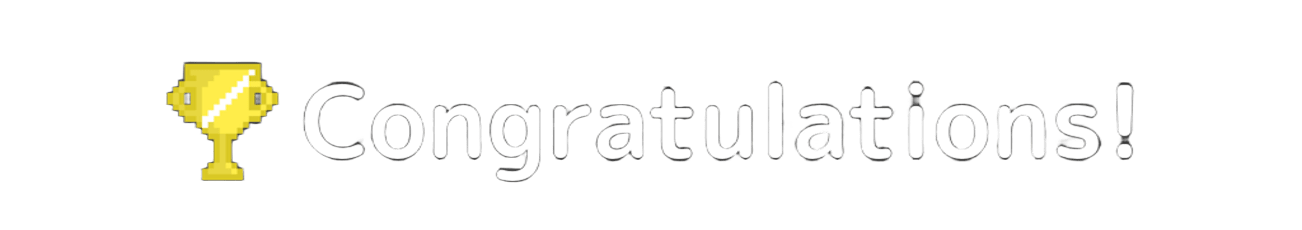